# LSTM OEDOMETER
## Load modules & Check PyTorch

In [1]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import Markdown, display

import pandas as pd

# data processing
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Debugger: Aktiviert
debug_mode = True
normalize = True

## Preloaded Modules

In [3]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.

    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """

    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"

    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.

    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.

    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """

    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred)  # Falls `delta_sigma_pred` ein 2D-Array ist

    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]),
        "delta_epsilon" : list(delta_epsilon[:min_len]),
        "sigma_t" : list(sigma_t[:min_len]),
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

## Check for use of CONDA if available

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

In [5]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005,
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]

        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])

        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen

    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])

    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')

    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
i = 1000

oedo_para = {
    'max_n': 1,
    'e_0': 1.0,
    'C_c': 0.005,
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 10000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), i)
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)

for i in range(i):
    oedo_para['sigma_t'] = sigma_t[i]
    oedo_para['delta_epsilon'] = delta_epsilon[i]
    oedo = Oedometer(**oedo_para)
    delta_sigma.append(round(oedo.delta_sigma[0], 2))


print('Anzahl Elemente delta_epsilon: ' + str(len(delta_epsilon)))
print('Anzahl Elemente sigma_t: ' + str(len(sigma_t)))
print('Anzahl Elemente delta_sigma: ' + str(len(delta_sigma)))

Anzahl Elemente delta_epsilon: 1000
Anzahl Elemente sigma_t: 1000
Anzahl Elemente delta_sigma: 1000


In [7]:
data = [
    ['sigma_t'] + sigma_t.tolist(),
    ['delta_sigma'] + delta_sigma,
    ['delta_epsilon'] + delta_epsilon.tolist()
    ]

df = pd.DataFrame(data)
# Markdown Headlin 'RawData'
display(Markdown('### RawData'))
display(Markdown(df.to_markdown()))

### RawData

|    | 0             |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |        11 |        12 |        13 |        14 |        15 |        16 |        17 |       18 |        19 |       20 |        21 |       22 |        23 |        24 |        25 |        26 |        27 |        28 |        29 |        30 |        31 |        32 |        33 |        34 |        35 |        36 |        37 |        38 |        39 |        40 |        41 |        42 |        43 |        44 |        45 |        46 |        47 |        48 |        49 |        50 |        51 |        52 |        53 |        54 |        55 |        56 |        57 |        58 |        59 |        60 |        61 |        62 |        63 |        64 |        65 |        66 |        67 |        68 |        69 |        70 |        71 |        72 |        73 |        74 |        75 |        76 |        77 |        78 |        79 |        80 |        81 |        82 |        83 |        84 |        85 |        86 |        87 |        88 |        89 |        90 |        91 |        92 |        93 |        94 |        95 |        96 |        97 |        98 |        99 |       100 |       101 |       102 |       103 |       104 |      105 |       106 |       107 |       108 |      109 |       110 |       111 |       112 |       113 |       114 |       115 |      116 |       117 |       118 |       119 |       120 |       121 |       122 |       123 |       124 |       125 |       126 |       127 |       128 |       129 |       130 |      131 |       132 |       133 |       134 |      135 |       136 |       137 |       138 |       139 |       140 |       141 |       142 |       143 |       144 |       145 |       146 |       147 |       148 |       149 |       150 |       151 |       152 |       153 |       154 |       155 |       156 |       157 |       158 |      159 |       160 |       161 |       162 |      163 |       164 |       165 |       166 |       167 |       168 |       169 |      170 |       171 |       172 |       173 |       174 |       175 |     176 |       177 |       178 |       179 |       180 |       181 |       182 |       183 |       184 |       185 |       186 |       187 |       188 |       189 |      190 |       191 |       192 |       193 |      194 |       195 |       196 |       197 |       198 |      199 |       200 |       201 |       202 |       203 |      204 |       205 |       206 |       207 |       208 |       209 |       210 |      211 |      212 |       213 |      214 |      215 |       216 |       217 |       218 |       219 |       220 |       221 |       222 |       223 |       224 |       225 |       226 |       227 |       228 |       229 |       230 |       231 |       232 |       233 |       234 |       235 |       236 |       237 |       238 |       239 |       240 |       241 |       242 |       243 |       244 |      245 |       246 |       247 |       248 |       249 |       250 |       251 |       252 |       253 |       254 |       255 |       256 |       257 |       258 |       259 |       260 |       261 |       262 |       263 |       264 |       265 |       266 |       267 |       268 |       269 |       270 |       271 |       272 |       273 |       274 |       275 |       276 |       277 |       278 |      279 |       280 |       281 |       282 |       283 |       284 |       285 |       286 |       287 |      288 |       289 |       290 |      291 |       292 |       293 |       294 |       295 |       296 |       297 |       298 |       299 |       300 |       301 |       302 |       303 |       304 |       305 |       306 |       307 |       308 |       309 |       310 |       311 |       312 |       313 |       314 |       315 |       316 |       317 |       318 |       319 |       320 |       321 |       322 |       323 |       324 |      325 |       326 |      327 |       328 |       329 |       330 |       331 |       332 |       333 |       334 |       335 |       336 |       337 |       338 |       339 |       340 |       341 |       342 |       343 |       344 |       345 |       346 |       347 |       348 |       349 |       350 |       351 |       352 |       353 |       354 |       355 |       356 |       357 |       358 |       359 |      360 |       361 |       362 |       363 |       364 |       365 |       366 |       367 |       368 |       369 |       370 |       371 |       372 |       373 |       374 |       375 |       376 |       377 |       378 |       379 |       380 |      381 |       382 |       383 |       384 |       385 |       386 |      387 |       388 |      389 |       390 |       391 |      392 |      393 |       394 |       395 |       396 |       397 |       398 |       399 |       400 |       401 |       402 |       403 |       404 |       405 |       406 |       407 |       408 |       409 |       410 |      411 |       412 |       413 |       414 |       415 |       416 |       417 |       418 |       419 |       420 |       421 |       422 |      423 |       424 |       425 |       426 |       427 |       428 |       429 |       430 |       431 |       432 |       433 |       434 |       435 |       436 |       437 |       438 |       439 |       440 |       441 |       442 |       443 |       444 |      445 |       446 |       447 |       448 |       449 |       450 |       451 |       452 |       453 |       454 |       455 |      456 |       457 |       458 |       459 |       460 |       461 |       462 |       463 |       464 |       465 |       466 |       467 |       468 |       469 |       470 |       471 |       472 |       473 |       474 |       475 |       476 |      477 |       478 |       479 |       480 |       481 |      482 |       483 |       484 |       485 |       486 |       487 |       488 |       489 |       490 |      491 |       492 |       493 |       494 |       495 |       496 |       497 |       498 |       499 |       500 |       501 |       502 |       503 |       504 |      505 |      506 |       507 |       508 |       509 |       510 |       511 |       512 |       513 |       514 |     515 |       516 |       517 |       518 |       519 |      520 |       521 |       522 |       523 |      524 |       525 |      526 |       527 |       528 |      529 |       530 |      531 |       532 |      533 |      534 |       535 |       536 |       537 |       538 |       539 |      540 |       541 |       542 |       543 |      544 |       545 |       546 |       547 |       548 |       549 |       550 |       551 |       552 |       553 |      554 |       555 |       556 |       557 |       558 |     559 |       560 |       561 |       562 |       563 |       564 |       565 |       566 |     567 |       568 |       569 |       570 |       571 |       572 |       573 |       574 |       575 |       576 |      577 |      578 |       579 |       580 |       581 |       582 |       583 |       584 |      585 |       586 |       587 |       588 |       589 |       590 |      591 |      592 |       593 |       594 |       595 |       596 |       597 |       598 |       599 |       600 |       601 |       602 |       603 |       604 |       605 |       606 |       607 |       608 |       609 |       610 |       611 |       612 |       613 |       614 |       615 |       616 |       617 |       618 |       619 |       620 |       621 |      622 |       623 |       624 |       625 |       626 |       627 |      628 |       629 |       630 |       631 |       632 |       633 |       634 |       635 |       636 |       637 |       638 |       639 |       640 |       641 |      642 |       643 |       644 |       645 |       646 |       647 |       648 |       649 |       650 |       651 |       652 |       653 |      654 |       655 |       656 |      657 |       658 |       659 |       660 |      661 |       662 |       663 |       664 |       665 |       666 |       667 |      668 |       669 |       670 |       671 |       672 |       673 |       674 |       675 |       676 |       677 |       678 |       679 |       680 |       681 |       682 |       683 |      684 |       685 |       686 |       687 |       688 |       689 |       690 |       691 |       692 |       693 |       694 |       695 |       696 |       697 |       698 |      699 |       700 |       701 |       702 |       703 |       704 |      705 |       706 |       707 |       708 |       709 |       710 |       711 |       712 |       713 |       714 |      715 |       716 |       717 |       718 |       719 |       720 |       721 |      722 |       723 |       724 |       725 |       726 |       727 |       728 |      729 |       730 |       731 |       732 |       733 |       734 |       735 |       736 |       737 |       738 |       739 |       740 |      741 |       742 |       743 |       744 |       745 |       746 |      747 |       748 |       749 |       750 |       751 |       752 |       753 |       754 |       755 |       756 |       757 |       758 |       759 |       760 |       761 |       762 |       763 |       764 |       765 |       766 |       767 |       768 |       769 |      770 |      771 |      772 |       773 |       774 |       775 |       776 |     777 |       778 |       779 |      780 |       781 |       782 |       783 |       784 |       785 |       786 |     787 |       788 |      789 |       790 |       791 |       792 |       793 |       794 |       795 |       796 |       797 |       798 |       799 |       800 |      801 |       802 |       803 |       804 |       805 |       806 |       807 |       808 |       809 |       810 |       811 |      812 |      813 |       814 |       815 |       816 |      817 |       818 |       819 |       820 |       821 |      822 |       823 |       824 |      825 |       826 |       827 |       828 |       829 |       830 |       831 |       832 |       833 |       834 |      835 |      836 |      837 |       838 |      839 |      840 |       841 |       842 |       843 |       844 |     845 |       846 |       847 |      848 |       849 |       850 |       851 |       852 |       853 |       854 |       855 |       856 |       857 |       858 |       859 |       860 |       861 |       862 |       863 |       864 |       865 |       866 |       867 |       868 |       869 |       870 |      871 |       872 |       873 |       874 |       875 |       876 |      877 |      878 |       879 |       880 |       881 |       882 |       883 |       884 |       885 |       886 |       887 |       888 |       889 |       890 |       891 |       892 |       893 |      894 |       895 |       896 |       897 |       898 |      899 |       900 |       901 |       902 |       903 |      904 |       905 |       906 |       907 |       908 |       909 |       910 |       911 |       912 |       913 |       914 |       915 |      916 |       917 |     918 |       919 |       920 |       921 |       922 |     923 |       924 |       925 |       926 |       927 |       928 |       929 |       930 |       931 |       932 |      933 |       934 |       935 |       936 |       937 |       938 |       939 |       940 |       941 |      942 |       943 |       944 |       945 |       946 |       947 |       948 |       949 |       950 |       951 |       952 |       953 |       954 |       955 |       956 |       957 |       958 |       959 |       960 |       961 |       962 |       963 |       964 |       965 |       966 |       967 |      968 |       969 |       970 |       971 |       972 |       973 |       974 |       975 |       976 |       977 |       978 |       979 |       980 |       981 |       982 |       983 |       984 |      985 |       986 |      987 |       988 |       989 |       990 |       991 |       992 |       993 |       994 |       995 |      996 |       997 |       998 |       999 |    1000 |
|---:|:--------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|---------:|----------:|---------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|---------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|---------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|--------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|--------:|
|  0 | sigma_t       | 8538      | 7976      | 9412      | 4104      | 7138      | 4806      | 3005      | 6066      | 5913      | 9249      | 9311      | 9431      | 3708      | 6863      | 4423      | 1359      | 9270      | 785      | 9328      | 540      | 6098      | 316      | 6365      | 4958      | 3542      | 2830      | 5899      | 3294      | 9171      | 5678      | 4151      | 5005      | 5781      | 2971      | 5601      | 2959      | 6004      | 7719      | 7822      | 1146      | 1306      | 9387      | 9550      | 2153      | 6649      | 2308      | 3776      | 3083      | 7171      | 3009      | 4332      | 3546      | 1618      | 8779      | 5619      | 4396      | 6693      | 7599      | 1127      | 6065      | 3908      | 7922      | 4267      | 3498      | 8211      | 7130      | 5015      | 4882      | 9848      | 8898      | 7968      | 6801      | 7615      | 3609      | 4744      | 1452      | 5594      | 9024      | 5486      | 3847      | 2710      | 8384      | 3893      | 6377      | 3754      | 7307      | 8165      | 1963      | 7024      | 4252      | 9022      | 6221      | 1524      | 7469      | 2880      | 9289      | 2117      | 4189      | 3673      | 1017      | 2111      | 6155      | 1947      | 5092      | 455      | 3300      | 7063      | 4427      | 949      | 3824      | 4064      | 8632      | 9871      | 2680      | 8888      | 661      | 2990      | 7703      | 4128      | 9595      | 1510      | 6225      | 6730      | 2640      | 4795      | 1441      | 5742      | 5731      | 7407      | 3888      | 433      | 5136      | 7766      | 5800      | 466      | 6520      | 2891      | 7432      | 6823      | 2417      | 4415      | 3087      | 7392      | 2544      | 1336      | 4481      | 4547      | 2346      | 6044      | 7829      | 5795      | 1156      | 4031      | 2827      | 8234      | 6781      | 1917      | 9983      | 912      | 4874      | 7957      | 7524      | 475      | 8228      | 5555      | 6110      | 1021      | 5028      | 9760      | 294      | 9616      | 6019      | 9084      | 8983      | 7403      | 41      | 8034      | 2948      | 8233      | 4781      | 5144      | 3015      | 8609      | 4876      | 4678      | 8607      | 7218      | 4431      | 7602      | 139      | 3544      | 1391      | 7334      | 472      | 8494      | 7099      | 6258      | 1654      | 734      | 8801      | 3211      | 9504      | 5483      | 177      | 9576      | 4154      | 8657      | 3853      | 2661      | 3742      | 582      | 777      | 8549      | 481      | 902      | 8483      | 5211      | 8215      | 8354      | 6915      | 5767      | 7901      | 4216      | 4961      | 6617      | 6315      | 3328      | 7938      | 4974      | 9007      | 3372      | 9287      | 7192      | 5740      | 3429      | 8916      | 4556      | 7815      | 9690      | 4233      | 4342      | 5310      | 2210      | 5484      | 855      | 9723      | 1858      | 1104      | 3408      | 7357      | 6753      | 4150      | 3815      | 1934      | 6005      | 7490      | 7949      | 2496      | 7724      | 9020      | 6714      | 7864      | 4134      | 2405      | 2093      | 7916      | 5587      | 5195      | 6987      | 1985      | 1412      | 3484      | 2074      | 1548      | 2030      | 3028      | 7141      | 3717      | 143      | 7183      | 8285      | 2842      | 5457      | 6471      | 7289      | 6437      | 1227      | 906      | 3128      | 2160      | 725      | 9241      | 2237      | 2333      | 7045      | 2473      | 7215      | 5881      | 4757      | 1928      | 6831      | 3379      | 7184      | 4105      | 9049      | 1419      | 9811      | 5637      | 9434      | 8093      | 7096      | 1714      | 7436      | 5604      | 8212      | 7994      | 5733      | 4430      | 4077      | 4163      | 4637      | 3979      | 6804      | 2010      | 103      | 9307      | 476      | 9423      | 5181      | 1293      | 2467      | 8909      | 6047      | 7017      | 6858      | 3749      | 7300      | 6336      | 6567      | 7582      | 5725      | 2904      | 7375      | 3236      | 5987      | 5299      | 7705      | 8002      | 6351      | 1937      | 7595      | 9769      | 8802      | 8441      | 6799      | 2684      | 9982      | 5841      | 3689      | 978      | 3345      | 8027      | 8627      | 5991      | 5858      | 2618      | 1673      | 2553      | 3135      | 9825      | 8300      | 6902      | 5059      | 2133      | 4211      | 7340      | 1889      | 9809      | 2622      | 4123      | 218      | 3060      | 8247      | 8325      | 8677      | 9585      | 222      | 6367      | 954      | 7015      | 2670      | 592      | 768      | 4083      | 6392      | 9110      | 2861      | 8526      | 6749      | 4846      | 8873      | 8190      | 9689      | 1310      | 9462      | 4417      | 5984      | 3584      | 8434      | 9087      | 599      | 9927      | 1170      | 1745      | 5822      | 4868      | 6499      | 1765      | 9880      | 7510      | 1168      | 4864      | 459      | 9204      | 7202      | 3511      | 1160      | 1274      | 8376      | 1530      | 8467      | 7637      | 5504      | 7607      | 9911      | 9901      | 2645      | 4192      | 8406      | 1086      | 3011      | 6595      | 3647      | 5667      | 221      | 7763      | 3774      | 7563      | 5073      | 5970      | 8255      | 1467      | 1214      | 2438      | 7841      | 165      | 3762      | 5569      | 9977      | 4967      | 7037      | 4918      | 2362      | 5547      | 8117      | 1666      | 2845      | 2920      | 9565      | 2757      | 3339      | 8030      | 4130      | 9538      | 8060      | 7795      | 689      | 6715      | 3821      | 2745      | 2279      | 448      | 6007      | 5654      | 6159      | 1129      | 4425      | 7497      | 2927      | 4352      | 175      | 7775      | 3178      | 9151      | 4830      | 4777      | 7556      | 4883      | 4421      | 2945      | 2297      | 4899      | 1164      | 1077      | 413      | 772      | 2870      | 9870      | 3221      | 4042      | 3833      | 2939      | 3144      | 3818      | 49      | 5701      | 1416      | 1236      | 9821      | 279      | 6822      | 1135      | 4533      | 454      | 6324      | 537      | 5358      | 9818      | 328      | 7788      | 981      | 2269      | 246      | 841      | 9713      | 6576      | 3714      | 8569      | 5928      | 231      | 7161      | 1284      | 9790      | 827      | 4793      | 1339      | 9641      | 4227      | 4247      | 7499      | 3727      | 1364      | 3403      | 375      | 1652      | 3219      | 4249      | 5127      | 80      | 4185      | 5550      | 4674      | 3249      | 5719      | 4692      | 1533      | 50      | 8790      | 8624      | 5243      | 7691      | 6682      | 3750      | 7770      | 1173      | 6061      | 264      | 325      | 6184      | 8563      | 3443      | 1331      | 1644      | 5249      | 303      | 8348      | 2264      | 4004      | 5314      | 7667      | 414      | 450      | 7953      | 3190      | 8313      | 5967      | 6960      | 2497      | 4021      | 4704      | 2941      | 3037      | 4088      | 8717      | 7339      | 5027      | 6175      | 7379      | 1299      | 6179      | 3460      | 2540      | 3336      | 9197      | 8512      | 3170      | 6727      | 2583      | 8335      | 9435      | 7174      | 150      | 8428      | 1702      | 3638      | 6961      | 5037      | 632      | 6457      | 2550      | 2071      | 3223      | 2537      | 8331      | 5820      | 4281      | 5723      | 3055      | 4327      | 2504      | 4701      | 825      | 6464      | 6051      | 6238      | 9697      | 2388      | 5562      | 5999      | 3602      | 8814      | 6233      | 7996      | 834      | 3983      | 5692      | 712      | 8288      | 2276      | 9604      | 520      | 7137      | 9406      | 1315      | 9791      | 7870      | 8958      | 471      | 6325      | 4005      | 5784      | 1390      | 5630      | 3198      | 9220      | 2416      | 4850      | 1583      | 5787      | 6118      | 4403      | 8780      | 1005      | 248      | 7485      | 7261      | 2730      | 9127      | 1180      | 8432      | 4420      | 7683      | 5895      | 3922      | 3303      | 5538      | 4797      | 8412      | 550      | 1539      | 8667      | 7249      | 5473      | 7153      | 525      | 5342      | 2347      | 5194      | 4561      | 9239      | 7073      | 8443      | 6029      | 3103      | 754      | 4377      | 9801      | 2299      | 9164      | 5762      | 1849      | 346      | 7185      | 7948      | 6485      | 5312      | 1469      | 9552      | 696      | 5945      | 3831      | 2713      | 2733      | 7888      | 2424      | 8713      | 1935      | 5471      | 8466      | 3651      | 910      | 9264      | 1332      | 1404      | 2025      | 9558      | 225      | 8865      | 6374      | 7612      | 7679      | 4172      | 5994      | 3450      | 8370      | 9940      | 7156      | 3287      | 3794      | 3105      | 5847      | 7796      | 7236      | 4714      | 5290      | 6283      | 8595      | 4747      | 4419      | 420      | 751      | 531      | 7406      | 3911      | 5204      | 2771      | 85      | 3124      | 9315      | 975      | 4358      | 2033      | 2240      | 4563      | 9320      | 2930      | 91      | 8795      | 613      | 4759      | 5391      | 3203      | 6462      | 5617      | 9174      | 6912      | 7441      | 2752      | 1450      | 3239      | 836      | 5397      | 8210      | 2373      | 1995      | 4278      | 8519      | 4488      | 9770      | 2702      | 4809      | 366      | 886      | 8924      | 6366      | 2541      | 947      | 1213      | 9889      | 3431      | 5632      | 290      | 3409      | 4487      | 241      | 2002      | 1100      | 1116      | 2366      | 6035      | 4202      | 7265      | 2286      | 1603      | 220      | 496      | 403      | 5714      | 529      | 272      | 6878      | 5865      | 9113      | 7003      | 70      | 8088      | 9666      | 984      | 7372      | 1238      | 9603      | 8706      | 2155      | 1842      | 6414      | 9599      | 4029      | 1410      | 2722      | 1148      | 6406      | 5438      | 1520      | 6689      | 9534      | 3194      | 6668      | 5244      | 9023      | 2006      | 504      | 2103      | 2239      | 1348      | 4179      | 9123      | 909      | 243      | 2352      | 9371      | 8673      | 7887      | 6465      | 9509      | 2762      | 5621      | 7291      | 5334      | 3134      | 7523      | 7966      | 2325      | 1547      | 372      | 3413      | 7867      | 4871      | 4902      | 789      | 6416      | 2588      | 9753      | 8584      | 249      | 2676      | 8773      | 9648      | 2984      | 1181      | 1801      | 9088      | 6425      | 9937      | 1124      | 1882      | 480      | 1283      | 33      | 9571      | 2812      | 4489      | 9605      | 66      | 2149      | 3240      | 3275      | 9344      | 8232      | 4261      | 5323      | 6839      | 8502      | 730      | 9834      | 1223      | 9301      | 6729      | 3390      | 7987      | 8365      | 1743      | 733      | 4739      | 1824      | 6141      | 7956      | 2868      | 8262      | 1544      | 8377      | 4028      | 4565      | 8241      | 3481      | 6254      | 9860      | 6090      | 3886      | 8991      | 8161      | 4919      | 6298      | 4071      | 1529      | 6142      | 8260      | 6147      | 312      | 5277      | 4496      | 6633      | 5430      | 7992      | 4409      | 2298      | 1513      | 4286      | 9206      | 2654      | 4948      | 2983      | 6587      | 6671      | 6581      | 648      | 4292      | 595      | 6468      | 3234      | 4277      | 5872      | 8298      | 2354      | 7878      | 8621      | 653      | 9740      | 7116      | 5653      | 67      |
|  1 | delta_sigma   | 1707.6    | 1595.2    | 1882.4    |  820.8    | 1427.6    |  961.2    |  601      | 1213.2    | 1182.6    | 1849.8    | 1862.2    | 1886.2    |  741.6    | 1372.6    |  884.6    |  271.8    | 1854      | 157      | 1865.6    | 108      | 1219.6    |  63.2    | 1273      |  991.6    |  708.4    |  566      | 1179.8    |  658.8    | 1834.2    | 1135.6    |  830.2    | 1001      | 1156.2    |  594.2    | 1120.2    |  591.8    | 1200.8    | 1543.8    | 1564.4    |  229.2    |  261.2    | 1877.4    | 1910      |  430.6    | 1329.8    |  461.6    |  755.2    |  616.6    | 1434.2    |  601.8    |  866.4    |  709.2    |  323.6    | 1755.8    | 1123.8    |  879.2    | 1338.6    | 1519.8    |  225.4    | 1213      |  781.6    | 1584.4    |  853.4    |  699.6    | 1642.2    | 1426      | 1003      |  976.4    | 1969.6    | 1779.6    | 1593.6    | 1360.2    | 1523      |  721.8    |  948.8    |  290.4    | 1118.8    | 1804.8    | 1097.2    |  769.4    |  542      | 1676.8    |  778.6    | 1275.4    |  750.8    | 1461.4    | 1633      |  392.6    | 1404.8    |  850.4    | 1804.4    | 1244.2    |  304.8    | 1493.8    |  576      | 1857.8    |  423.4    |  837.8    |  734.6    |  203.4    |  422.2    | 1231      |  389.4    | 1018.4    |  91      |  660      | 1412.6    |  885.4    | 189.8    |  764.8    |  812.8    | 1726.4    | 1974.2    |  536      | 1777.6    | 132.2    |  598      | 1540.6    |  825.6    | 1919      |  302      | 1245      | 1346      |  528      |  959      |  288.2    | 1148.4    | 1146.2    | 1481.4    |  777.6    |  86.6    | 1027.2    | 1553.2    | 1160      |  93.2    | 1304      |  578.2    | 1486.4    | 1364.6    |  483.4    |  883      |  617.4    | 1478.4    |  508.8    |  267.2    |  896.2    |  909.4    |  469.2    | 1208.8    | 1565.8    | 1159      |  231.2    |  806.2    |  565.4    | 1646.8    | 1356.2    |  383.4    | 1996.6    | 182.4    |  974.8    | 1591.4    | 1504.8    |  95      | 1645.6    | 1111      | 1222      |  204.2    | 1005.6    | 1952      |  58.8    | 1923.2    | 1203.8    | 1816.8    | 1796.6    | 1480.6    |  8.2    | 1606.8    |  589.6    | 1646.6    |  956.2    | 1028.8    |  603      | 1721.8    |  975.2    |  935.6    | 1721.4    | 1443.6    |  886.2    | 1520.4    |  27.8    |  708.8    |  278.2    | 1466.8    |  94.4    | 1698.8    | 1419.8    | 1251.6    |  330.8    | 146.8    | 1760.2    |  642.2    | 1900.8    | 1096.6    |  35.4    | 1915.2    |  830.8    | 1731.4    |  770.6    |  532.2    |  748.4    | 116.4    | 155.4    | 1709.8    |  96.2    | 180.4    | 1696.6    | 1042.2    | 1643      | 1670.8    | 1383      | 1153.4    | 1580.2    |  843.2    |  992.2    | 1323.4    | 1263      |  665.6    | 1587.6    |  994.8    | 1801.4    |  674.4    | 1857.4    | 1438.4    | 1148      |  685.8    | 1783.2    |  911.2    | 1563      | 1938      |  846.6    |  868.4    | 1062      |  442      | 1096.8    | 171      | 1944.6    |  371.6    |  220.8    |  681.6    | 1471.4    | 1350.6    |  830      |  763      |  386.8    | 1201      | 1498      | 1589.8    |  499.2    | 1544.8    | 1804      | 1342.8    | 1572.8    |  826.8    |  481      |  418.6    | 1583.2    | 1117.4    | 1039      | 1397.4    |  397      |  282.4    |  696.8    |  414.8    |  309.6    |  406      |  605.6    | 1428.2    |  743.4    |  28.6    | 1436.6    | 1657      |  568.4    | 1091.4    | 1294.2    | 1457.8    | 1287.4    |  245.4    | 181.2    |  625.6    |  432      | 145      | 1848.2    |  447.4    |  466.6    | 1409      |  494.6    | 1443      | 1176.2    |  951.4    |  385.6    | 1366.2    |  675.8    | 1436.8    |  821      | 1809.8    |  283.8    | 1962.2    | 1127.4    | 1886.8    | 1618.6    | 1419.2    |  342.8    | 1487.2    | 1120.8    | 1642.4    | 1598.8    | 1146.6    |  886      |  815.4    |  832.6    |  927.4    |  795.8    | 1360.8    |  402      |  20.6    | 1861.4    |  95.2    | 1884.6    | 1036.2    |  258.6    |  493.4    | 1781.8    | 1209.4    | 1403.4    | 1371.6    |  749.8    | 1460      | 1267.2    | 1313.4    | 1516.4    | 1145      |  580.8    | 1475      |  647.2    | 1197.4    | 1059.8    | 1541      | 1600.4    | 1270.2    |  387.4    | 1519      | 1953.8    | 1760.4    | 1688.2    | 1359.8    |  536.8    | 1996.4    | 1168.2    |  737.8    | 195.6    |  669      | 1605.4    | 1725.4    | 1198.2    | 1171.6    |  523.6    |  334.6    |  510.6    |  627      | 1965      | 1660      | 1380.4    | 1011.8    |  426.6    |  842.2    | 1468      |  377.8    | 1961.8    |  524.4    |  824.6    |  43.6    |  612      | 1649.4    | 1665      | 1735.4    | 1917      |  44.4    | 1273.4    | 190.8    | 1403      |  534      | 118.4    | 153.6    |  816.6    | 1278.4    | 1822      |  572.2    | 1705.2    | 1349.8    |  969.2    | 1774.6    | 1638      | 1937.8    |  262      | 1892.4    |  883.4    | 1196.8    |  716.8    | 1686.8    | 1817.4    | 119.8    | 1985.4    |  234      |  349      | 1164.4    |  973.6    | 1299.8    |  353      | 1976      | 1502      |  233.6    |  972.8    |  91.8    | 1840.8    | 1440.4    |  702.2    |  232      |  254.8    | 1675.2    |  306      | 1693.4    | 1527.4    | 1100.8    | 1521.4    | 1982.2    | 1980.2    |  529      |  838.4    | 1681.2    |  217.2    |  602.2    | 1319      |  729.4    | 1133.4    |  44.2    | 1552.6    |  754.8    | 1512.6    | 1014.6    | 1194      | 1651      |  293.4    |  242.8    |  487.6    | 1568.2    |  33      |  752.4    | 1113.8    | 1995.4    |  993.4    | 1407.4    |  983.6    |  472.4    | 1109.4    | 1623.4    |  333.2    |  569      |  584      | 1913      |  551.4    |  667.8    | 1606      |  826      | 1907.6    | 1612      | 1559      | 137.8    | 1343      |  764.2    |  549      |  455.8    |  89.6    | 1201.4    | 1130.8    | 1231.8    |  225.8    |  885      | 1499.4    |  585.4    |  870.4    |  35      | 1555      |  635.6    | 1830.2    |  966      |  955.4    | 1511.2    |  976.6    |  884.2    |  589      |  459.4    |  979.8    |  232.8    |  215.4    |  82.6    | 154.4    |  574      | 1974      |  644.2    |  808.4    |  766.6    |  587.8    |  628.8    |  763.6    |  9.8    | 1140.2    |  283.2    |  247.2    | 1964.2    |  55.8    | 1364.4    |  227      |  906.6    |  90.8    | 1264.8    | 107.4    | 1071.6    | 1963.6    |  65.6    | 1557.6    | 196.2    |  453.8    |  49.2    | 168.2    | 1942.6    | 1315.2    |  742.8    | 1713.8    | 1185.6    |  46.2    | 1432.2    |  256.8    | 1958      | 165.4    |  958.6    |  267.8    | 1928.2    |  845.4    |  849.4    | 1499.8    |  745.4    |  272.8    |  680.6    |  75      |  330.4    |  643.8    |  849.8    | 1025.4    | 16      |  837      | 1110      |  934.8    |  649.8    | 1143.8    |  938.4    |  306.6    | 10      | 1758      | 1724.8    | 1048.6    | 1538.2    | 1336.4    |  750      | 1554      |  234.6    | 1212.2    |  52.8    |  65      | 1236.8    | 1712.6    |  688.6    |  266.2    |  328.8    | 1049.8    |  60.6    | 1669.6    |  452.8    |  800.8    | 1062.8    | 1533.4    |  82.8    |  90      | 1590.6    |  638      | 1662.6    | 1193.4    | 1392      |  499.4    |  804.2    |  940.8    |  588.2    |  607.4    |  817.6    | 1743.4    | 1467.8    | 1005.4    | 1235      | 1475.8    |  259.8    | 1235.8    |  692      |  508      |  667.2    | 1839.4    | 1702.4    |  634      | 1345.4    |  516.6    | 1667      | 1887      | 1434.8    |  30      | 1685.6    |  340.4    |  727.6    | 1392.2    | 1007.4    | 126.4    | 1291.4    |  510      |  414.2    |  644.6    |  507.4    | 1666.2    | 1164      |  856.2    | 1144.6    |  611      |  865.4    |  500.8    |  940.2    | 165      | 1292.8    | 1210.2    | 1247.6    | 1939.4    |  477.6    | 1112.4    | 1199.8    |  720.4    | 1762.8    | 1246.6    | 1599.2    | 166.8    |  796.6    | 1138.4    | 142.4    | 1657.6    |  455.2    | 1920.8    | 104      | 1427.4    | 1881.2    |  263      | 1958.2    | 1574      | 1791.6    |  94.2    | 1265      |  801      | 1156.8    |  278      | 1126      |  639.6    | 1844      |  483.2    |  970      |  316.6    | 1157.4    | 1223.6    |  880.6    | 1756      |  201      |  49.6    | 1497      | 1452.2    |  546      | 1825.4    |  236      | 1686.4    |  884      | 1536.6    | 1179      |  784.4    |  660.6    | 1107.6    |  959.4    | 1682.4    | 110      |  307.8    | 1733.4    | 1449.8    | 1094.6    | 1430.6    | 105      | 1068.4    |  469.4    | 1038.8    |  912.2    | 1847.8    | 1414.6    | 1688.6    | 1205.8    |  620.6    | 150.8    |  875.4    | 1960.2    |  459.8    | 1832.8    | 1152.4    |  369.8    |  69.2    | 1437      | 1589.6    | 1297      | 1062.4    |  293.8    | 1910.4    | 139.2    | 1189      |  766.2    |  542.6    |  546.6    | 1577.6    |  484.8    | 1742.6    |  387      | 1094.2    | 1693.2    |  730.2    | 182      | 1852.8    |  266.4    |  280.8    |  405      | 1911.6    |  45      | 1773      | 1274.8    | 1522.4    | 1535.8    |  834.4    | 1198.8    |  690      | 1674      | 1988      | 1431.2    |  657.4    |  758.8    |  621      | 1169.4    | 1559.2    | 1447.2    |  942.8    | 1058      | 1256.6    | 1719      |  949.4    |  883.8    |  84      | 150.2    | 106.2    | 1481.2    |  782.2    | 1040.8    |  554.2    | 17      |  624.8    | 1863      | 195      |  871.6    |  406.6    |  448      |  912.6    | 1864      |  586      | 18.2    | 1759      | 122.6    |  951.8    | 1078.2    |  640.6    | 1292.4    | 1123.4    | 1834.8    | 1382.4    | 1488.2    |  550.4    |  290      |  647.8    | 167.2    | 1079.4    | 1642      |  474.6    |  399      |  855.6    | 1703.8    |  897.6    | 1954      |  540.4    |  961.8    |  73.2    | 177.2    | 1784.8    | 1273.2    |  508.2    | 189.4    |  242.6    | 1977.8    |  686.2    | 1126.4    |  58      |  681.8    |  897.4    |  48.2    |  400.4    |  220      |  223.2    |  473.2    | 1207      |  840.4    | 1453      |  457.2    |  320.6    |  44      |  99.2    |  80.6    | 1142.8    | 105.8    |  54.4    | 1375.6    | 1173      | 1822.6    | 1400.6    | 14      | 1617.6    | 1933.2    | 196.8    | 1474.4    |  247.6    | 1920.6    | 1741.2    |  431      |  368.4    | 1282.8    | 1919.8    |  805.8    |  282      |  544.4    |  229.6    | 1281.2    | 1087.6    |  304      | 1337.8    | 1906.8    |  638.8    | 1333.6    | 1048.8    | 1804.6    |  401.2    | 100.8    |  420.6    |  447.8    |  269.6    |  835.8    | 1824.6    | 181.8    |  48.6    |  470.4    | 1874.2    | 1734.6    | 1577.4    | 1293      | 1901.8    |  552.4    | 1124.2    | 1458.2    | 1066.8    |  626.8    | 1504.6    | 1593.2    |  465      |  309.4    |  74.4    |  682.6    | 1573.4    |  974.2    |  980.4    | 157.8    | 1283.2    |  517.6    | 1950.6    | 1716.8    |  49.8    |  535.2    | 1754.6    | 1929.6    |  596.8    |  236.2    |  360.2    | 1817.6    | 1285      | 1987.4    |  224.8    |  376.4    |  96      |  256.6    |  6.6    | 1914.2    |  562.4    |  897.8    | 1921      | 13.2    |  429.8    |  648      |  655      | 1868.8    | 1646.4    |  852.2    | 1064.6    | 1367.8    | 1700.4    | 146      | 1966.8    |  244.6    | 1860.2    | 1345.8    |  678      | 1597.4    | 1673      |  348.6    | 146.6    |  947.8    |  364.8    | 1228.2    | 1591.2    |  573.6    | 1652.4    |  308.8    | 1675.4    |  805.6    |  913      | 1648.2    |  696.2    | 1250.8    | 1972      | 1218      |  777.2    | 1798.2    | 1632.2    |  983.8    | 1259.6    |  814.2    |  305.8    | 1228.4    | 1652      | 1229.4    |  62.4    | 1055.4    |  899.2    | 1326.6    | 1086      | 1598.4    |  881.8    |  459.6    |  302.6    |  857.2    | 1841.2    |  530.8    |  989.6    |  596.6    | 1317.4    | 1334.2    | 1316.2    | 129.6    |  858.4    | 119      | 1293.6    |  646.8    |  855.4    | 1174.4    | 1659.6    |  470.8    | 1575.6    | 1724.2    | 130.6    | 1948      | 1423.2    | 1130.6    | 13.4    |
|  2 | delta_epsilon |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |   0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |

In [19]:
x1    = data[0][1:] 
x2    = data[2][1:]
y     = data[1][1:]    

seq_len = 25                       # Lookback
def make_seq(a, b, y, L):
    X, Y = [], []
    for i in range(len(y)-L):
        X.append(np.stack([a[i:i+L], b[i:i+L]], axis=1))  # (L,2)
        Y.append(y[i+L])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
    return X, Y

X, Y = make_seq(x1, x2, y, seq_len)
print(X.shape, Y.shape)            # (samples, L, 2) / (samples,1)

torch.Size([975, 25, 2]) torch.Size([975, 1])


# 2) LSTM-Modell definieren

In [10]:
class NonLinearLSTM(nn.Module):
    def __init__(self, in_dim=2, h_dim=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, h_dim, layers, batch_first=True)
        self.head = nn.Sequential(
            nn.ReLU(),           # Non-Linärität
            nn.Linear(h_dim,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)      # out: (B,L,h_dim)
        out     = self.head(out[:,-1])  # letztes Zeitschritt
        return out, hc

# 3) Training

In [14]:
model = NonLinearLSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 250
hc = None
for ep in range(1, epochs+1):
    model.train(); optimiser.zero_grad()
    pred, hc = model(X, hc)
    loss = criterion(pred, Y)
    loss.backward(); optimiser.step()
    hc = tuple(h.detach() for h in hc)
    if ep % 25 == 0:
        print(f"Epoch {ep:3d} | loss {loss.item():.6f}")

lstm.weight_ih_l0 tensor(4.4929)
lstm.weight_hh_l0 tensor(0.0027)
lstm.bias_ih_l0 tensor(0.0149)
lstm.bias_hh_l0 tensor(0.0149)
lstm.weight_ih_l1 tensor(0.5249)
lstm.weight_hh_l1 tensor(0.2821)
lstm.bias_ih_l1 tensor(2.6773)
lstm.bias_hh_l1 tensor(2.6773)
head.1.weight tensor(3.5447)
head.1.bias tensor(56.7016)
head.3.weight tensor(84.4579)
head.3.bias tensor(1961.0973)
lstm.weight_ih_l0 tensor(10.2786)
lstm.weight_hh_l0 tensor(0.0025)
lstm.bias_ih_l0 tensor(0.0121)
lstm.bias_hh_l0 tensor(0.0121)
lstm.weight_ih_l1 tensor(0.7058)
lstm.weight_hh_l1 tensor(0.3710)
lstm.bias_ih_l1 tensor(3.4538)
lstm.bias_hh_l1 tensor(3.4538)
head.1.weight tensor(3.7281)
head.1.bias tensor(59.1092)
head.3.weight tensor(91.9316)
head.3.bias tensor(1961.0614)
lstm.weight_ih_l0 tensor(2.7656)
lstm.weight_hh_l0 tensor(0.0014)
lstm.bias_ih_l0 tensor(0.0064)
lstm.bias_hh_l0 tensor(0.0064)
lstm.weight_ih_l1 tensor(0.7519)
lstm.weight_hh_l1 tensor(0.3886)
lstm.bias_ih_l1 tensor(3.4745)
lstm.bias_hh_l1 tensor(3.474


KeyboardInterrupt



In [12]:
# 4) Vorhersage & Plot

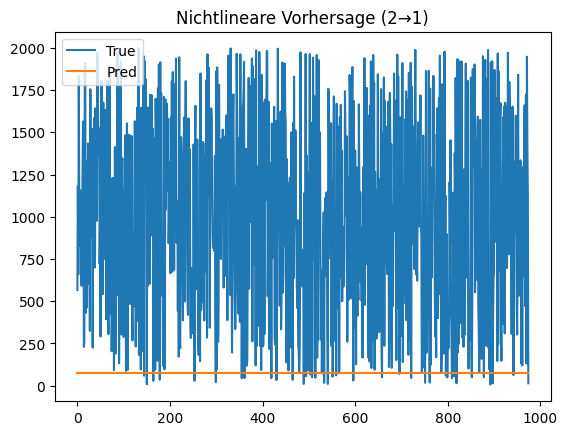

In [13]:
model.eval()
with torch.no_grad():
    y_hat, _ = model(X)
y_hat = y_hat.squeeze().numpy()

import matplotlib.pyplot as plt
plt.plot(y[seq_len:], label="True")
plt.plot(y_hat,       label="Pred")
plt.title("Nichtlineare Vorhersage")
plt.legend(); plt.show()